# Financial Modeling and Estimation

v1.0 (2018 Fall) Nikunj Jain

This notebook is meant to provide a basic walkthrough through some basic techniques into modeling the stock market. We will not be presenting very advanced methods, and you should feel free to explore a lot beyond what this notebook presents. However, as an overview, these are the steps we will follow:
1. Getting data
2. Data cleaning and exploratory analysis
3. A basic linear regression model

This has been extensively adapted (for code and basic analysis) from <a href="https://pythonprogramming.net/forecasting-predicting-machine-learning-tutorial/">this</a> article.

## <font color = blue> Getting Data</font>

Before we go into making any models, we first need some data to play around with! The library we will be using is a personal favorite, called <a href="https://www.quandl.com/tools/python">Quandl</a>. This is in no means exhaustive or comprehensive, so feel free to augment these data sets as you see fit. You will need to sign up for a (free) account and include your own API key at the spot indicated.

In [5]:
%matplotlib inline

import quandl as Quandl
Quandl.ApiConfig.api_key = "EGdC1RASF31yDGeBDRt7"
import numpy as np
import pandas as pd
import math
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
style.use('ggplot')

## Get top 200 tech stock data

We scraped the top 200 tech companies from NASDAQ (https://www.nasdaq.com/screening/companies-by-industry.aspx?industry=Technology) and pulled their data into this notebook.

In [6]:
def fetch_prices(ticker_list, limit=None):
    '''
    takes in ticker list of strings and pulls in their data from quandl
    can limit number of stocks to query with limit param
    '''
    if limit:
        ticker_list = ticker_list[:limit]
        
    out_dict = {}
    for ticker_str in ticker_list:
    #     print(ticker_str)
        try:
            ticker_df = Quandl.get(ticker_str,api_key="EGdC1RASF31yDGeBDRt7")
            out_dict[ticker_str] = ticker_df
        except: 
            print(ticker_str + " does not exist on Quandl's side.")
    return out_dict

In [7]:
tech_tickers = np.array([a.strip().upper() for a in pd.read_csv('companylist.csv')['Symbol']])
quandl_codes_tech_tickers = ["WIKI/"+ticker for ticker in tech_tickers]

Get the ticker data!

In [8]:
tech_data = fetch_prices(quandl_codes_tech_tickers, limit=10)

WIKI/VNET does not exist on Quandl's side.
WIKI/JOBS does not exist on Quandl's side.
WIKI/WUBA does not exist on Quandl's side.
WIKI/ACIA does not exist on Quandl's side.


## Example looking at a couple plots

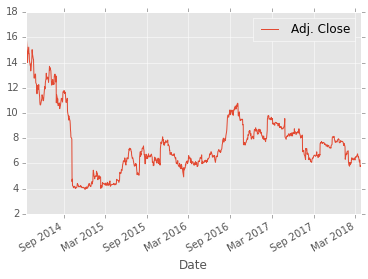

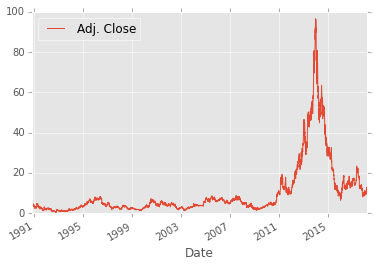

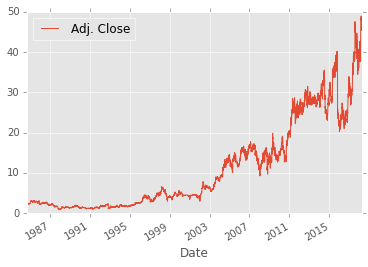

In [9]:
for df in tech_data.values()[:3]:
    df.plot(y=['Adj. Close'])

## <font color = blue>Data Cleaning and Exploratory Analysis</font>

Now that we have all this data, what should we use? This is, in general, an excellent question, and has been studied extensively. To get you started, <a href="https://towardsdatascience.com/feature-engineering-in-stock-market-prediction-quantifying-market-vs-fundamentals-3895ab9f311f">here</a> is an excellent article,
<a href="http://worldcomp-proceedings.com/proc/p2012/ICA4753.pdf">here</a> is an empirical study, and <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6643074">here</a> is a more technically heavy <i>(codeword for, "Read at your own risk!")</i> paper presenting a detailed approach to selecting features. The article does not explicitly talk about feature selection, but presents a general overview on how to approach these problems.

Another avenue people explore is <i><b>data augmentation</b></i> which essentially uses additional and non-conventional data sources to predict stock movement. Indeed, <a href="https://www.newsweek.com/how-satellite-surveillance-helping-predict-stock-prices-skynet-562973">this</a> is a very interesting article talking about how people are using satellite imagery to model parts of the market! If you find a generally open source database with publicly available data, feel free to use it (with appropriate citations) in your project. 


### Our data

For our problem, we will not do anything this complicated. Notice, the data frame has a large amount of stock related data for Google. There are two sets of features (which seem repeated!): Open/High/Low/Close/Volume, and $\textit{Adjusted}$ Open/High/Low/Close/Volume. <b>We will be using the second set of values</b>. For those not interested in the technical details, you can simply continue on your merry way with this. For those curious:

Figuring out the values of stocks can be more complex than checking their price on any specific day. Stocks have both a "closing price" and an "adjusted closing price." These prices reflect two different ways of determining the value of the stock. The closing price is simply the cash value of that specific piece of stock at day's end while the adjusted closing price reflects the closing price of the stock in relation to other stock attributes. In general, the adjusted closing price is considered to be a more technically accurate reflection of the true value of the stock. The adjusted closing price analyzes the stock's dividends, stock splits and new stock offerings to determine an adjusted value. <a href="https://www.investopedia.com/terms/a/adjusted_closing_price.asp">Here</a> is a more detailed explanation.

### Also note the (as appropriate) scaling and data cleaning steps we take. It is generally in your interest to ensure that your data is well cleaned and prepared, as this is foundational in ensuring good models. We will also add two new features:
1. Percent change in the opening and closing prices (measured from the opening)
2. The percent change of the maximum difference during the day (high v/s low) (measured from the close) 
#### We do this as often, relative change is a better indicator than absolute change.

### Clean the DFs

In [10]:
def clean_df(df):
    # Pick the needed columns
    df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]

    # Create new features (percent change)
    df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
    df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

    # Only keep the relative values now
    df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
    
    return df

In [11]:
def prep_naive_train_test(df):
    '''prep df for train test using starter featurization'''
    
    '''params:
            forecast 5% future values 
            feature to forecaset: closing price
    '''
    
    # This is what we really want to predict
    forecast_col = 'Adj. Close'
    percentage_to_forecast = 0.05
    
    # How do you deal with null/missing data? One approach is to replace it with some numerical placeholder for negative infinity.
    df.fillna(value=-99999, inplace=True)

    # We will try to predict the next 5% of the values
    forecast_out = int(math.ceil(0.05 * len(df)))

    df['label'] = df[forecast_col].shift(-forecast_out)
    X = np.array(df.drop(['label'], 1))

    # Use the "scale" feature of sklearn to rescale the data onto the same scale
    X = preprocessing.scale(X)

    # Only use the training set, and leave some values to predict on
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]

    df.dropna(inplace=True)
    y = np.array(df['label'])
    return X,y,X_lately

Now, to forecast out, we need some data. We decided that we're forecasting out 1% of the data, thus we will want to, or at least *can* generate forecasts for each of the final 1% of the dataset. So when can we do this? When would we identify that data? We could call it now, but consider the data we're trying to forecast is not scaled like the training data was. Okay, so then what? Do we just do preprocessing.scale() against the last 1%? The scale method scales based on all of the known data that is fed into it. Ideally, you would scale both the training, testing, AND forecast/predicting data all together. Is this always possible or reasonable? No. If you can do it, you should, however. In our case, right now, we can do it. Our data is small enough and the processing time is low enough, so we'll preprocess and scale the data all at once.

In many cases, you wont be able to do this. Imagine if you were using gigabytes of data to train a classifier. It may take days to train your classifier, you wouldn't want to be doing this every...single...time you wanted to make a prediction. Thus, you may need to either NOT scale anything, or you may scale the data separately. As usual, you will want to test both options and see which is best in your specific case.

In [12]:
clean_dfs = {}
train_test_data = {}
for df, ticker in list(zip(tech_data.values(),tech_data.keys())):
    curr_clean_df = clean_df(df)
    clean_dfs[ticker] = curr_clean_df
    X,y,X_lately = prep_naive_train_test(curr_clean_df)
    train_test_data[ticker] = (X,y,X_lately)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


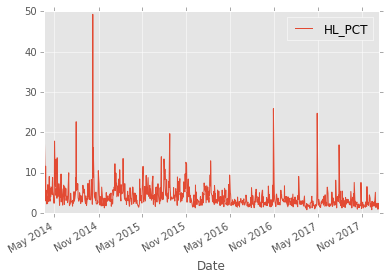

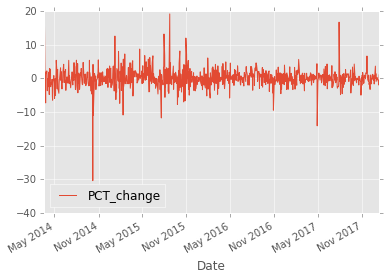

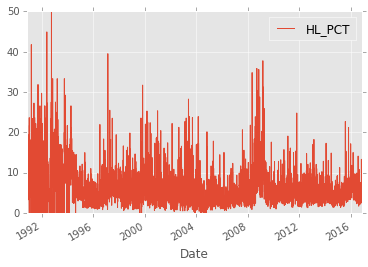

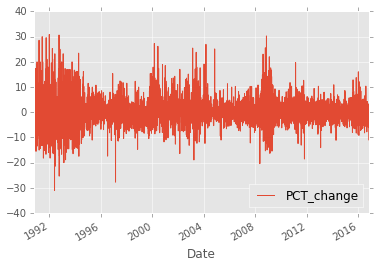

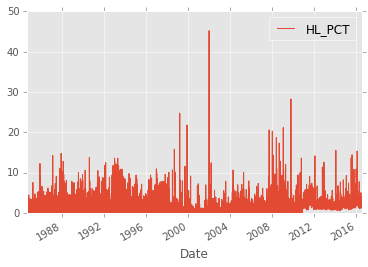

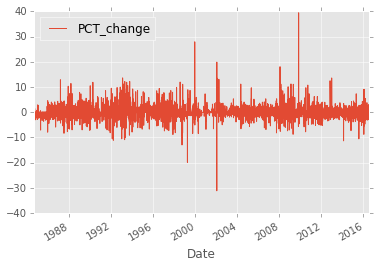

In [13]:
for df in clean_dfs.values()[:3]:
    df.plot(y='HL_PCT')
    df.plot(y='PCT_change')

## <font color = blue> A Basic Linear Regression Model </font>

Given appropriately scaled features and a stock that seems to have reasonably bounded volatility, as well as some linear trend to it, it is not unreasonable to start to model it with a basic linear fit. I will stress that creating a linear model with say >90% accuracy is not that great. I certainly wouldn't trade stocks on it. There are still many issues to consider, especially with different companies that have different price trajectories over time. Google really is very linear: Up and to the right. Many companies aren't, so keep this in mind. 

In [14]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

# Fit a linear regression model to the data
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

0.371758159143


/Library/Python/2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


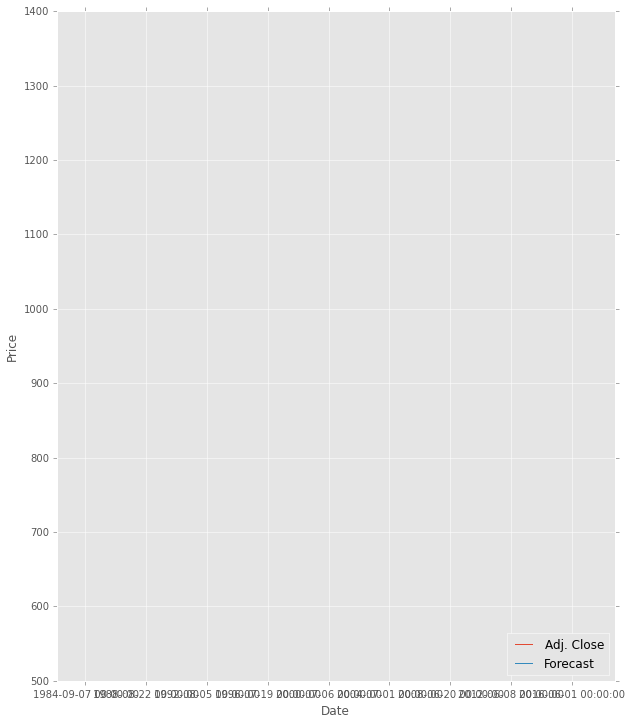

In [15]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.date()
one_day = 86400
next_unix = last_unix + datetime.timedelta(days=1)


for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

fig, ax = plt.subplots(figsize=(10, 12))
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
ax.set_ylim([500, 1400])
ax.set_xlim([datetime.date(2000, 1, 26), datetime.date(2018, 6, 1)])
plt.show()

### This seems to resemble our data and the trend we actually observed during that time. We do not go into indepth analysis of the model here, but leave this as a good starting point. Some basic extensions to this model include: predicting not just values, but <i> confidence intervals </i> around the prediction (using various models for the noise). The next natural step would be to extend this to a more complicated model!

# Single Stock Featurization

In [15]:
from ta import *

In [16]:
df = Quandl.get("WIKI/GOOGL",api_key="EGdC1RASF31yDGeBDRt7")
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [17]:
# Add ta features filling NaN values
df = add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)

/Library/Python/2.7/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/Library/Python/2.7/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


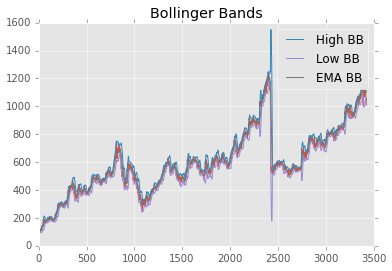

In [22]:
plt.plot(df.Close)
plt.plot(df.volatility_bbh, label='High BB')
plt.plot(df.volatility_bbl, label='Low BB')
plt.plot(df.volatility_bbm, label='EMA BB')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

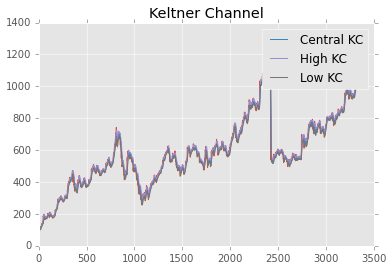

In [21]:
plt.plot(df.Close)
plt.plot(df.volatility_kcc, label='Central KC')
plt.plot(df.volatility_kch, label='High KC')
plt.plot(df.volatility_kcl, label='Low KC')
plt.title('Keltner Channel')
plt.legend()
plt.show()

Indices from NASDAQOMX (https://www.quandl.com/data/NASDAQOMX-NASDAQ-OMX-Global-Index-Data?keyword=technology):
    
    --------- SECTOR INDICATORS ----------
    
    NASDAQ-100 Ex-Tech Sector (NDXX)
    NASDAQ-100 Technology Sector (NDXT)
    NASDAQ-100 Target 25 Index(NDXT25)
    NASDAQ-100 Technology Sector Total Return (NTTR)
    
    --------- MARKET INDICATORS -----------
    
    NASDAQ N America Index (NQNA)
    NASDAQ US All Market Index (NQUSA)

    NASDAQ US 1500 Index (NQUSS1500)
    NASDAQ US 450 Index (NQUSM450)
    NASDAQ US 300 Index (NQUSL300)

    NASDAQ US Small Cap Index (NQUSS)
    NASDAQ US Large Cap Index (NQUSL)
    NASDAQ US Mid Cap Index (NQUSM)
    
    Nasdaq US Sustainable Momentum Index (NQSUMO)
    
    
    
Indices from URC (https://www.quandl.com/data/URC-Unicorn-Research-Corporation?page=3):

    --------- MARKET INDICATORS -----------

    All of them on the NASDAQ
    
    
      
    
    
    
        
      
**TODO**: 

-calculate stock-industry beta   
-calculate stock-market beta   
-calculate industry-market beta

In [23]:
sector_idcs = ['NDXX','NDXT','NDXT25', 'NTTR']
market_idcs = ['NQNA', 'NQUSA', 'NQUSS1500', 'NQUSM450', 'NQUSL300', 'NQUSS', 'NQUSL', 'NQUSM', 'NQSUMO']
sector_idcs, market_idcs = ["NASDAQOMX/"+t for t in sector_idcs], ["NASDAQOMX/"+t for t in market_idcs]

In [4]:
sector_data, market_data = fetch_prices(sector_idcs), fetch_prices(market_idcs)


NameError: name 'fetch_prices' is not defined